# Lending Club Case Study - Exploratory Data Analysis

**Group Members:**
Karthik M Nair
Hiep V Dang

## **Project Brief** 

Solving this assignment will give you an idea about how real business problems are solved using EDA. In this case study, apart from applying the techniques you have learnt in EDA, you will also develop a basic understanding of risk analytics in banking and financial services and understand how data is used to minimise the risk of losing money while lending to customers.

## **Business Understanding** 
You work for a consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:<br>
If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company.<br>
If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.<br>
The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.<br>
In this case study, you will use EDA to understand how **consumer attributes** and **loan attributes** influence the tendency of default.

When a person applies for a loan, there are **two types of decisions** that could be taken by the company:<br><br>
  **1. Loan accepted:** If the company approves the loan, there are 3 possible scenarios described below:<br>
       **Fully paid:** Applicant has fully paid the loan (the principal and the interest rate)<br>
       **Current:** Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.<br>
       **Charged-off:** Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan<br><br>
  **2. Loan rejected:** The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)<br>

## **Business Objective**

This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface.<br>
Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss). The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who **default** cause the largest amount of loss to the lenders. In this case, the customers labelled as 'charged-off' are the 'defaulters'.

If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.<br>
In other words, the company wants to understand the **driving factors (or driver variables)** behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.

## **Import Packages**

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 130, 'display.max_columns', 130)
pd.options.display.float_format = '{:,.2f}'.format

## **Load Raw Data**

In [2]:
# Load Raw Data
data = pd.read_csv(
    'loan.csv',
    low_memory=False,
    index_col='id',
    dtype={
        'id':object, 
        'member_id': object
    }
)

## **Clean Data**

### Drop empty columns

In [3]:
# Drop empty columns
data.dropna(how='all',axis=1,inplace=True)

### Drop invariant variables

In [4]:
# Drop invariant variables
data = data[[col for col in data.columns if len(data[col].unique()) > 1]]

### Drop irrelevant variables

There are some variables that are fundamentally irrelevant to the ability of payback. Hence, we can use our business judgements to safely remove these data

In [5]:
# Drop irrelevant variables
data.drop(
    labels=[
        'member_id',
        'zip_code',
        'url',
        'title',
        'desc',
        'tax_liens',
        'emp_title',
        'chargeoff_within_12_mths',
        'collections_12_mths_ex_med',
    ],
    axis=1,
    inplace=True
)

### Drop columns that have too many missing values

In [6]:
# Drop columns that have significant in number of missing values
for col in data.columns:
    missing_values = data[col].isna().sum()
    if missing_values / data.shape[0] >= 0.1:
        data.drop(col, axis=1, inplace=True)

### Drop row that have too many missing values

In [7]:
# Drop rows that have significant in number of missing values
for row in data.index:
    missing_values = data.loc[row].isna().sum()
    if missing_values / data.shape[1] >= 0.1:
        data.drop(row, axis=1, inplace=True)

### Convert percentage strings to decimal numbers

Data read from .csv files could be parsed as strings rather than implying data type. For example, 20.50% could be parsed as "20.50%" (a string) instead of actual percentage. In order to conduct the analysis, we must convert these strings to floating numbers

In [8]:
# Clean percentages: convert string to number
def convert_pct_string(x):
    if x == x: # If x is not NaN, it must be equal to itself
        result = float(x.rstrip('%'))
    else:
        result = x
    return result
column_list = ['int_rate', 'revol_util']
for col in column_list:
    data[col] = data[col].map(convert_pct_string)

### Convert date strings to dates

We also need to convert date strings to dates

In [9]:
# Clean dates: convert string to date
def convert_date_string(x):
    if x == x: # If x is not NaN, it must be equal to itself
        result = dt.datetime.strptime(x,'%b-%y').date()
    else:
        result = x
    return result
column_list = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in column_list:
    data[col] = data[col].map(convert_date_string)

## Exploratory Data Analysis

Definition: Througout our analysis, **Default Ratio (%)** on each segment is calculated as the ratio of borrowers in a particular segment who actually defaulted on the total number of borrowers in that segment.

### Analysis on Grade & Default Risk

Our very first analysis is to look at the grade assigned to each loan's application. Fundamentally speaking, loan's grade reflects how risky a loan is and how likely it could be charged off. Here, we would like to see if loans of better grades was actually safer than those of worse grades.

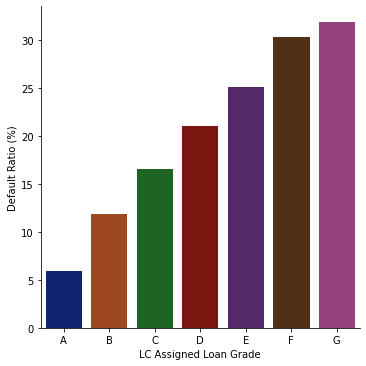

In [10]:
# Calculate Default Ratio by Grade group
default_ratio_by_grade = data.groupby(['grade','loan_status'])['loan_status'].count().unstack(level=1)
default_ratio_by_grade.fillna(0,inplace=True)
borrowers_by_grade = default_ratio_by_grade.sum(axis=1)
default_ratio_by_grade['default_ratio'] = default_ratio_by_grade['Charged Off'] / borrowers_by_grade * 100
default_ratio_by_grade = default_ratio_by_grade[['default_ratio']]
default_ratio_by_grade.reset_index(inplace=True)

# Graph
g = sns.catplot(data=default_ratio_by_grade,kind='bar',x='grade',y='default_ratio',palette='dark')
g.set_axis_labels('LC Assigned Loan Grade','Default Ratio (%)')

As can be seen, default ratio consistently increases from best grades to worst grades. It confirms that **we incur greater risk of default with loans of bad grades**. Next, we will go further by breaking down grades into subgrades

### Analysis on Sub-grade & Default Risk

Here, we will take a further step to see what happens between subgrades

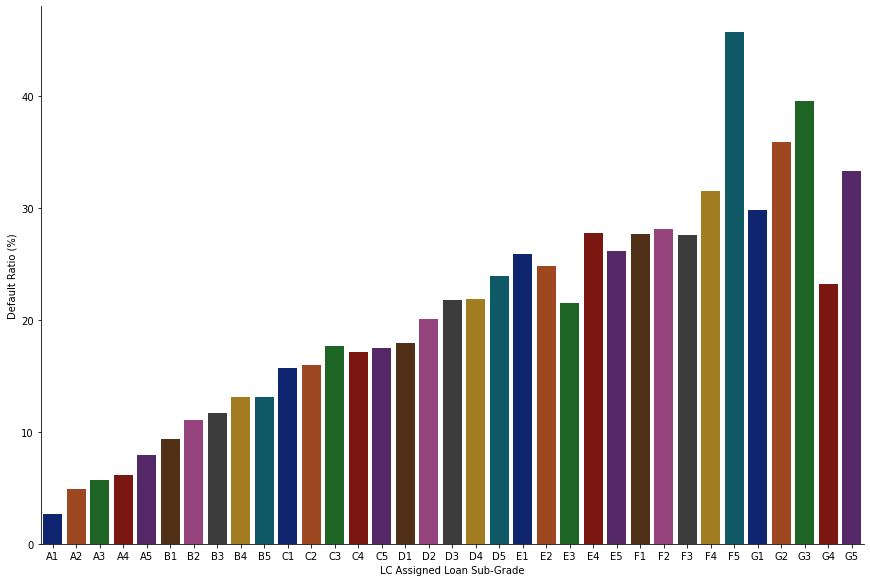

In [11]:
# Calculate Default Ratio by Sub-grade group
default_ratio_by_subgrade = data.groupby(['sub_grade','loan_status'])['loan_status'].count().unstack(level=1)
default_ratio_by_subgrade.fillna(0,inplace=True)
borrowers_by_subgrade = default_ratio_by_subgrade.sum(axis=1)
default_ratio_by_subgrade['default_ratio'] = default_ratio_by_subgrade['Charged Off'] / borrowers_by_subgrade * 100
default_ratio_by_subgrade = default_ratio_by_subgrade[['default_ratio']]
default_ratio_by_subgrade.reset_index(inplace=True)

# Graph
g = sns.catplot(
    data=default_ratio_by_subgrade,
    kind='bar',
    x='sub_grade',
    y='default_ratio',
    palette='dark',
    height=8, 
    aspect=12/8,
    
)
g.set_axis_labels('LC Assigned Loan Sub-Grade','Default Ratio (%)')

As demonstrated above, **the relationship between assigned subgrades and default ratio remains consistent from subgrades A1 to F5**. The only exception is seen among subgrades in grade G. There is no clear evidence of the trend, this could be explained by there are only few borrowers classified into these subgrades; hence, the default ratio could varies due to small sample size.

### Analysis on Loan Term & Default Risk

This analysis answers the question whether longer-term an shorter-term loans are invariant with respect to default ratio

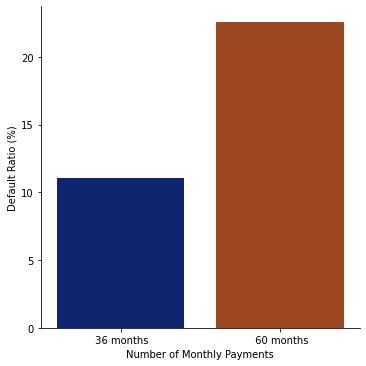

In [12]:
# Calculate Default Ratio by Term
default_ratio_by_term = data.groupby(['term','loan_status'])['loan_status'].count().unstack(level=1)
default_ratio_by_term.fillna(0,inplace=True)
borrowers_by_term = default_ratio_by_term.sum(axis=1)
default_ratio_by_term['default_ratio'] = default_ratio_by_term['Charged Off'] / borrowers_by_term * 100
default_ratio_by_term = default_ratio_by_term[['default_ratio']]
default_ratio_by_term.reset_index(inplace=True)

# Graph
g = sns.catplot(data=default_ratio_by_term,kind='bar',x='term',y='default_ratio',palette='dark')
g.set_axis_labels('Number of Monthly Payments','Default Ratio (%)')

Loans with 36 monthly payments are greatly safer than loans with 60 monthly payments. In another word, **shorter term implies less default risk and vice versa**

### Analysis on Income Level & Default Risk

In this analysis, we divide the borrowers into 4 groups corresponding to their income level:

1. Below 25th percentile: income_level = 'low'
2. From 25th percentile to 50th percentile: income_level = 'lower_medium'
3. From 50th percentile to 75th percentile: income_level = 'upper_medium'
4. Above 75th percentile: income_level = 'high'

We first do the classification:

In [13]:
# Classify customers by income levels
def income_classifier(income_series):
    first_quartile = income_series.quantile(0.25)
    second_quartile = income_series.quantile(0.5)
    third_quartile = income_series.quantile(0.75)
    result = income_series.copy()
    result.loc[income_series < first_quartile] = 'low'
    result.loc[(first_quartile <= income_series) & (income_series < second_quartile)] = 'lower_medium'
    result.loc[(second_quartile <= income_series) & (income_series < third_quartile)] = 'upper_medium'
    result.loc[third_quartile <= income_series] = 'high'
    return result
data['income_level'] = data['annual_inc'].transform(income_classifier)

In [14]:
# Calculate Default Ratio by Employment
default_ratio_by_employment = data.groupby(['income_level','emp_length','loan_status'])['loan_status'].count().unstack(level=2)
default_ratio_by_employment.fillna(0,inplace=True)
borrowers_by_employment = default_ratio_by_employment.sum(axis=1)
default_ratio_by_employment['default_ratio'] = default_ratio_by_employment['Charged Off'] / borrowers_by_employment * 100
default_ratio_by_employment = default_ratio_by_employment['default_ratio']
flattened_table = default_ratio_by_employment.reset_index() # create a flattened table for graphing
default_ratio_by_employment = default_ratio_by_employment.unstack(level=1)
default_ratio_by_employment = default_ratio_by_employment.loc[[
    'low',
    'lower_medium',
    'upper_medium',
    'high',
]]
default_ratio_by_employment = default_ratio_by_employment[[
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years',
]]

print(default_ratio_by_employment)

emp_length    < 1 year  1 year  2 years  3 years  4 years  5 years  6 years  \
income_level                                                                  
low              16.79   17.82    17.01    16.29    17.30    15.68    16.01   
lower_medium     14.22   14.09    13.06    13.50    11.92    14.27    13.74   
upper_medium     12.21   11.86    10.37    13.92    13.89    13.55    12.96   
high             10.32   10.36     9.12     9.78    10.53    12.31    12.50   

emp_length    7 years  8 years  9 years  10+ years  
income_level                                        
low             21.19    18.88    14.22      19.81  
lower_medium    15.45    11.86    15.02      17.39  
upper_medium    11.92    13.61    12.78      15.93  
high            12.27    12.06     9.21      10.92  


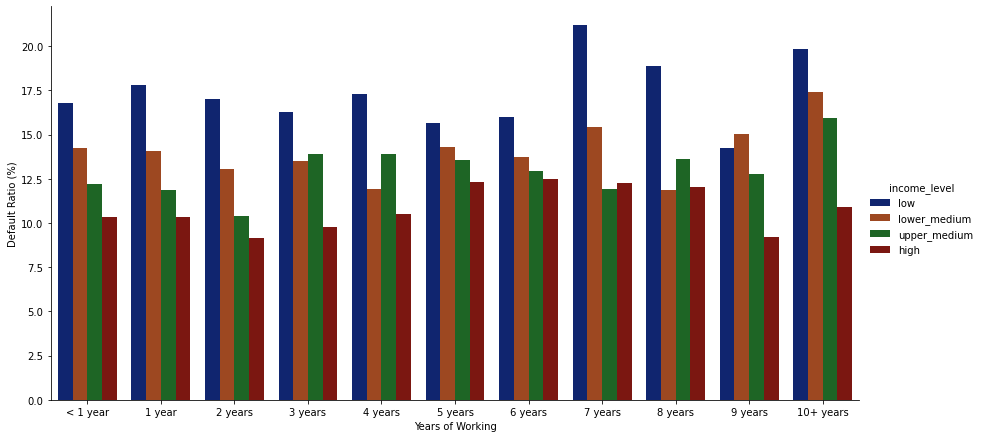

In [15]:
g = sns.catplot(
    data=flattened_table,
    kind='bar',
    x='emp_length',
    y='default_ratio',
    hue='income_level',
    palette='dark',
    orient='v',
    hue_order=[
        'low',
        'lower_medium',
        'upper_medium',
        'high',
    ],
    order=[
        '< 1 year',
        '1 year',
        '2 years',
        '3 years',
        '4 years',
        '5 years',
        '6 years',
        '7 years',
        '8 years',
        '9 years',
        '10+ years',
    ],
    height=6, 
    aspect=12/6,
)
g.set_axis_labels('Years of Working','Default Ratio (%)')

**Year of working seems unable to tell if the borrower would go default or not**. But it was very clear that income level has a negative relationship with default ratio, **higher income implies less default risk and vice versa.**

### Analysis on Income Verification Status & Default Risk

In [16]:
# Calculate Default Ratio by Verification
default_ratio_by_verification = data.groupby(['verification_status','income_level','loan_status'])['loan_status'].count().unstack(level=2)
default_ratio_by_verification.fillna(0,inplace=True)
borrowers_by_verification = default_ratio_by_verification.sum(axis=1)
default_ratio_by_verification['default_ratio'] = default_ratio_by_verification['Charged Off'] / borrowers_by_verification * 100
default_ratio_by_verification = default_ratio_by_verification['default_ratio']
flattened_table = default_ratio_by_verification.reset_index() # create a flattened table for graphing
default_ratio_by_verification = default_ratio_by_verification.unstack(level=1)
default_ratio_by_verification = default_ratio_by_verification.loc[[
    'Not Verified',
    'Verified',
    'Source Verified',
]]
default_ratio_by_verification =  default_ratio_by_verification[[
    'low',
    'lower_medium',
    'upper_medium',
    'high',
]]

print(default_ratio_by_verification)

income_level          low  lower_medium  upper_medium  high
verification_status                                        
Not Verified        15.96         12.41         11.50  8.94
Verified            21.79         18.68         15.61 12.26
Source Verified     17.97         14.26         14.37 10.17


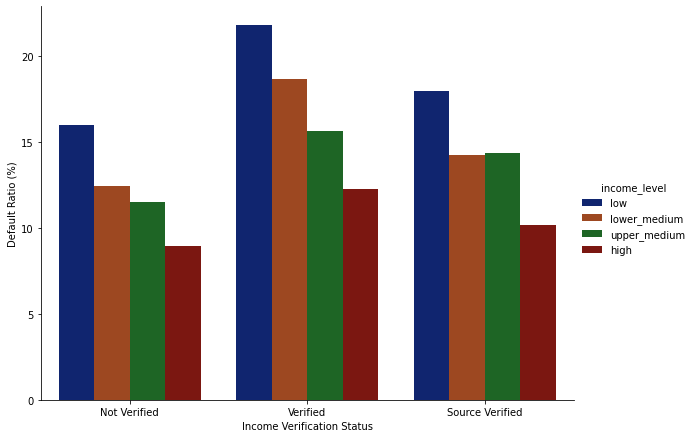

In [17]:
g = sns.catplot(
    data=flattened_table,
    kind='bar',
    x='verification_status',
    y='default_ratio',
    hue='income_level',
    palette='dark',
    orient='v',
    hue_order=[
        'low',
        'lower_medium',
        'upper_medium',
        'high',
    ],
    order=[
        'Not Verified',
        'Verified',
        'Source Verified',
    ],
    height=6, 
    aspect=8/6,
)
g.set_axis_labels('Income Verification Status','Default Ratio (%)')

The default risk consistently decrease from higher income levels to lower income levels are align with previous analysis. However, there seems no relationship between income verification status and default ratio. This result suggests that **income verification step seems unneccessary** in the loan application process.

### Analysis on Loan Purpose & Default Risk

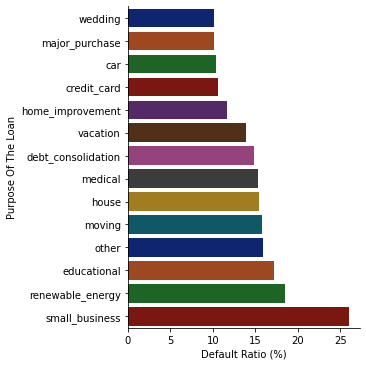

In [18]:
# Calculate Default Ratio by Purpose
default_ratio_by_purpose = data.groupby(['purpose','loan_status'])['loan_status'].count().unstack(level=1)
default_ratio_by_purpose.fillna(0,inplace=True)
borrowers_by_purpose = default_ratio_by_purpose.sum(axis=1)
default_ratio_by_purpose['default_ratio'] = default_ratio_by_purpose['Charged Off'] / borrowers_by_purpose * 100
default_ratio_by_purpose = default_ratio_by_purpose[['default_ratio']]
default_ratio_by_purpose.reset_index(inplace=True)
default_ratio_by_purpose.sort_values('default_ratio',inplace=True)

# Graph
g = sns.catplot(data=default_ratio_by_purpose,kind='bar',y='purpose',x='default_ratio',orient='h',palette='dark')
g.set_axis_labels('Default Ratio (%)','Purpose Of The Loan')

As we can see, **loans offered for financing small businesses are extremely risky with more than 25% chance of default**. Loans for renewable energy and education also exhibit great possibility of default. **Loans for weddings, major purchases, cars and credit card repayments are safest.**

### Analysis on Geography and Default Rate

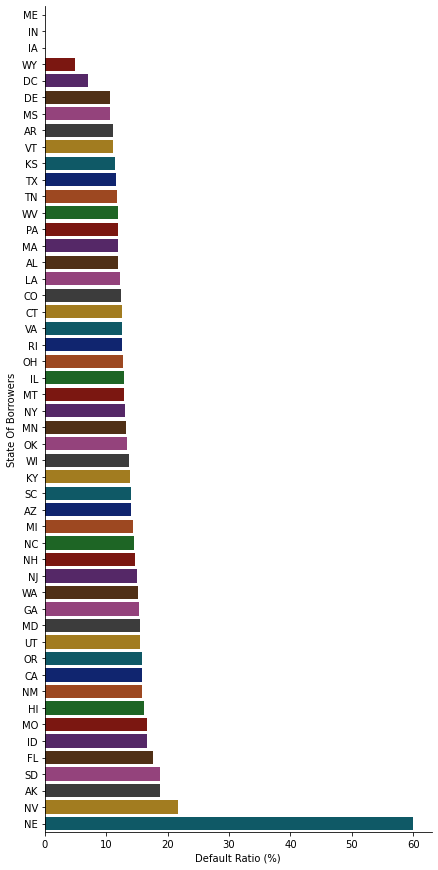

In [20]:
# Calculate Default Ratio by state
default_ratio_by_state = data.groupby(['addr_state','loan_status'])['loan_status'].count().unstack(level=1)
default_ratio_by_state.fillna(0,inplace=True)
borrowers_by_state = default_ratio_by_state.sum(axis=1)
default_ratio_by_state['default_ratio'] = default_ratio_by_state['Charged Off'] / borrowers_by_state * 100
default_ratio_by_state = default_ratio_by_state[['default_ratio']]
default_ratio_by_state.reset_index(inplace=True)
default_ratio_by_state.sort_values('default_ratio',inplace=True)

# Graph
g = sns.catplot(
    data=default_ratio_by_state,
    kind='bar',
    y='addr_state',
    x='default_ratio',
    orient='h',
    palette='dark',
    height=12, 
    aspect=6/12,
)
g.set_axis_labels('Default Ratio (%)','State Of Borrowers')

**Loans offered in State NE are immensely risky with 60% chance of default. Loans in ME, IN, IA, WY, DC are considered safest**